In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Vamos a calcular el omega bar y el Rcorot para los diferentes lbar 

In [1]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GD_new.dat')
time_M31gd  = data[:,0]
lbar1_M31gd = data[:,1]
lbar3_M31gd = data[:,3]
lbar4_M31gd = data[:,4]
lbar5_M31gd = data[:,5]

# print(lbar1_M31gd[0])

In [2]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GS_001_new.dat')
time_M31gs  = data[:,0]
lbar1_M31gs = data[:,1]
lbar3_M31gs = data[:,3]
lbar4_M31gs = data[:,4]
lbar5_M31gs = data[:,5]

# print(lbar1_M31gs[0])

data = np.loadtxt('../_data/correcciones/lbar_time_GS_002_new.dat')
time_MWgs  = data[:,0]
lbar1_MWgs = data[:,1]
lbar3_MWgs = data[:,3]
lbar4_MWgs = data[:,4]
lbar5_MWgs = data[:,5]

# print(lbar1_MWgs[0])

### Omega_bar GADGET

In [40]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from matplotlib.ticker import MultipleLocator


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
archivo = open(path2 + 'omega_set_GD.dat','a')


path = '/mnt/is2/alejandro/ornella/'
# snapshot=range(496,300,-1)
# for isnap in snapshot:

isnap = 496
snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
halos = (0,1,3)

# for i in halos:
i = 0
cm   = snap['subhalo_'+ str('%03d' %i) + '/Center'][()]
r200 = snap['subhalo_'+ str('%03d' %i) + '/R200'][()]

pstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Coordinates'][()]
IDs  = snap['subhalo_'+ str('%03d' %i) + '/Str/Ids'][()]
mstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Masses'][()]
vel  = snap['subhalo_'+ str('%03d' %i) + '/Str/Velocities'][()]

pgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Coordinates'][()]
mgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Masses'][()]

pdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Coordinates'][()]
mdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Masses'][()]

z = a0/aexp[isnap] - 1.
Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
# time = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
mstr = mstr/h
mgas = mgas/h
mdrk = mdrk/h

r200 = r200*aexp[isnap]/h
rgal = 0.15*r200

limit = np.where(rstr<rgal)
r_sort = np.sort(rstr[limit])
r_indice = np.argsort(rstr[limit])

Mc_str = np.cumsum((mstr[limit])[r_indice])
M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
razon = Mc_str/M_gal
cincuenta, = np.where(razon < 0.5)

r50 = r_sort[cincuenta][-1]              

#------------------masa total en r200 (Mvir)--------------------------         
veloc,=np.where(rstr<r50)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
rtot = np.concatenate([rstr, rgas, rdrk])
mtot = np.concatenate([mstr, mgas, mdrk])

limit_tot   = np.where(rtot<r200)
rtot_sort   = np.sort(rtot[limit_tot])
rtot_indice = np.argsort(rtot[limit_tot])

Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
#--------------------------------------------------------------
omega_circ= Vtot/rtot_sort



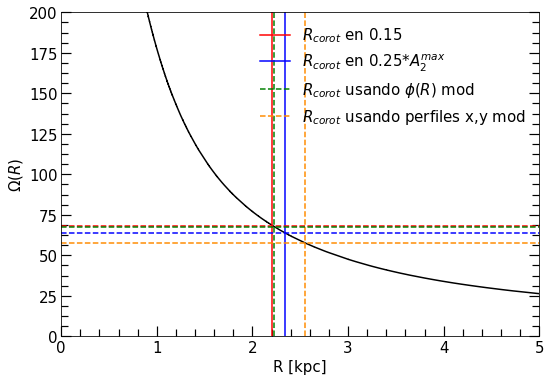

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))#, sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(rtot_sort, omega_circ, color='k')
ax.axvline(x=rcorot11_M31gd,color='r', label='$R_{corot}$ en 0.15')
ax.axvline(x=rcorot31_M31gd,color='b',label='$R_{corot}$ en 0.25*$A_2^{max}$')
# ax.axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
ax.axvline(x=rcorot51_M31gd,color='g',label='$R_{corot}$ usando $\phi(R)$ mod', ls='--')
# ax.axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
ax.axvline(x=rcorot61_M31gd,color='darkorange',label='$R_{corot}$ usando perfiles x,y mod', ls='--')
ax.axhline(y=omega11_M31gd,color='r', ls='--')
ax.axhline(y=omega51_M31gd,color='g', ls='--')
ax.axhline(y=omega31_M31gd,color='b', ls='--')
ax.axhline(y=omega61_M31gd,color='darkorange', ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\Omega(R)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylim(0,200)
ax.set_xlim(0,5)
ax.legend(fontsize=15,frameon=False,loc=1)

### Omega_bar GASOLINE 

In [32]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from matplotlib.ticker import MultipleLocator

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

# for j in range(len(snapshot)-1,32,-1):
    
path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
archivo = open(path2 + 'omega_set_GS.dat','a')
    
    
j=0

snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

halos =(1,2)#4)

for i in halos:
    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]
    
    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]
    
    pgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Coordinates'][()]
    mgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Masses'][()]

    pdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Coordinates'][()]
    mdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Masses'][()]
    
#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
#----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)
    
    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
#------------------------------------------------------------------
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt(G*Mc_tot/rtot_sort)
#--------------------------------------------------------------
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn


    mask_supreme, = np.where((Rn<3.*aexp) & (zn<1.*aexp) & (zn>-1.*aexp))

    nbin=20
    med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

    omega_mean   = np.zeros(nbin)

    for j in range(0,nbin):
        mask, = np.where((Rn[mask_supreme] > nodos[j]) & (Rn[mask_supreme] < nodos[j+1]))

        omega_mean[j] = np.mean(omega[mask_supreme][mask])
    
    lbar1 = GASOLINE[i-1,1]
    lbar2 = GASOLINE[i-1,2]
    lbar3 = GASOLINE[i-1,3]
    lbar4 = GASOLINE[i-1,4]
    
    finterp2 = sint.interp1d(med,omega_mean,fill_value="extrapolate")
    omegabar1 = finterp2(lbar1)
    omegabar2 = finterp2(lbar2)
    omegabar3 = finterp2(lbar3)
    omegabar4 = finterp2(lbar4)

    print 'lbar1 = ', lbar1
    print 'lbar2 = ', lbar2
    print 'lbar3 = ', lbar3
    print 'lbar4 = ', lbar4

    print 'omega_bar1 = ', omegabar1
    print 'omega_bar2 = ', omegabar2
    print 'omega_bar3 = ', omegabar3
    print 'omega_bar4 = ', omegabar4

    omega_circ= Vtot/rtot_sort

    finterp3 = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
    rcorot1 = finterp3(omegabar1)
    rcorot2 = finterp3(omegabar2)
    rcorot3 = finterp3(omegabar3)
    rcorot4 = finterp3(omegabar4)

    print 'Rcorot1 = ', rcorot1
    print 'Rcorot2 = ', rcorot2
    print 'Rcorot3 = ', rcorot3
    print 'Rcorot4 = ', rcorot4
    
    print '-----------------------------------------'
    
    archivo.write(str('%s'%i) +'\t'+
                   str('%12.8f'% omegabar1) +'\t'+
                   str('%12.8f'% omegabar2) +'\t'+
                   str('%12.8f'% omegabar3) +'\t'+
                   str('%12.8f'% omegabar4) +'\t'+
                   str('%12.8f'% rcorot1) +'\t'+
                   str('%12.8f'% rcorot2) +'\t'+
                   str('%12.8f'% rcorot3) +'\t'+
                   str('%12.8f'% rcorot4) +'\n')
archivo.close()

/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in divide


lbar1 =  0.85810894
lbar2 =  1.3638804
lbar3 =  0.92665375
lbar4 =  1.21384032
omega_bar1 =  83.43567038002838
omega_bar2 =  53.25802642422172
omega_bar3 =  74.49940887727698
omega_bar4 =  57.47002067452044
Rcorot1 =  1.8426896109520101
Rcorot2 =  2.766363812700705
Rcorot3 =  2.0377790895521084
Rcorot4 =  2.576845984408707
-----------------------------------------
lbar1 =  1.30868324
lbar2 =  3.10774342
lbar3 =  1.45032536
lbar4 =  3.09512256
omega_bar1 =  24.97101292351368
omega_bar2 =  5.093760062194269
omega_bar3 =  23.961081255576623
omega_bar4 =  5.235787136365618
Rcorot1 =  4.960487940824958
Rcorot2 =  24.382448129933998
Rcorot3 =  5.169314076559146
Rcorot4 =  23.721767668492653
-----------------------------------------


### Hacemos los plots de font 

In [3]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GD_new.dat')
# time_M31gd  = data[:,0]
lbar1_M31gd = data[0,1]
# lbar2_M31gd = data[0,2]
lbar3_M31gd = data[0,3]
lbar4_M31gd = data[0,4]
lbar5_M31gd = data[0,5]
# lbar6_M31gd = data[0,6]

data = np.loadtxt('../_data/correcciones/lbar_time_GS_001_new.dat')
# time_M31gs  = data[:,0]
lbar1_M31gs = data[0,1]
# lbar2_M31gs = data[0,2]
lbar3_M31gs = data[0,3]
lbar4_M31gs = data[0,4]
lbar5_M31gs = data[0,5]
# lbar6_M31gs = data[0,6]

data = np.loadtxt('../_data/correcciones/lbar_time_GS_002_new.dat')
# time_MWgs  = data[:,00
lbar1_MWgs = data[0,1]
# lbar2_MWgs = data[0,2]
lbar3_MWgs = data[0,3]
lbar4_MWgs = data[0,4]
lbar5_MWgs = data[0,5]
# lbar6_MWgs = data[0,6]

In [4]:
lbar_M31gd = (lbar1_M31gd + lbar3_M31gd + lbar4_M31gd + lbar5_M31gd) / 4
lmin_M31gd = min(lbar1_M31gd,lbar3_M31gd,lbar4_M31gd,lbar5_M31gd)
lmax_M31gd = max(lbar1_M31gd,lbar3_M31gd,lbar4_M31gd,lbar5_M31gd)

lbar_M31gs = (lbar1_M31gs + lbar3_M31gs + lbar4_M31gs + lbar5_M31gs) / 4
lmin_M31gs = min(lbar1_M31gs,lbar3_M31gs,lbar4_M31gs,lbar5_M31gs)
lmax_M31gs = max(lbar1_M31gs,lbar3_M31gs,lbar4_M31gs,lbar5_M31gs)

lbar_MWgs = (lbar1_MWgs + lbar3_MWgs + lbar4_MWgs + lbar5_MWgs) / 4
lmin_MWgs = min(lbar1_MWgs,lbar3_MWgs,lbar4_MWgs,lbar5_MWgs)
lmax_MWgs = max(lbar1_MWgs,lbar3_MWgs,lbar4_MWgs,lbar5_MWgs)

print(lbar_M31gd, lbar_M31gs, lbar_MWgs)

(1.4045634475, 0.8963142125000001, 1.4560262750000001)


In [5]:
### ------- DATOS DE FONT -------------------------
import numpy as np

path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/datos/Font2017_data/'
tab1 = np.loadtxt(path + 'tabla1.dat')
dist = tab1[:,0]
r_25 = tab1[:,1]
Mstr = tab1[:,5]

path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/datos/Font2017_data/'
tab2 = np.loadtxt(path + 'tabla2.dat')
rCR    = tab2[:,0]
rCR_er = tab2[:,1]
omega  = tab2[:,2]
om_low = tab2[:,3]
om_up  = tab2[:,4]
Sbar   = tab2[:,5]
R      = tab2[:,6]
R_er   = tab2[:,7]


path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/datos/Font2017_data/'
tab2b = np.loadtxt(path + 'tabla2b.dat')
rho_e  = tab2b[:,0]
rho_er = tab2b[:,1]
rho_b  = tab2b[:,2]
rho_br = tab2b[:,3]

conv = dist*1e3*np.pi/(180.*3600)
rbar = 0.5*(rho_e + rho_b)
rbar2 = rbar*conv

sigma_rbar = 0.5* np.abs(rho_e-rho_b) *conv

rCR2 = rCR*conv
sigma_rCR = rCR_er*conv

In [6]:
### ------- DATOS DE CORSINI -------------------------
path = '/home/omarioni/'

read    = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/datos/datos_corsini.dat')
l_bar   = read[:,0]
lbar_e  = read[:,1]
lbar_er = read[:,2]
rcor    = read[:,3]
rcor_e  = read[:,4]
rcor_er = read[:,5]
om_cor  = read[:,6]
eom_cor = read[:,7]

In [7]:
### ------- DATOS DE ALGORRY -------------------------
read2    = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/datos/algorry_omegalbar.dat')
lbar_david = read2[:,0]
omeg_david = read2[:,1]

om_david = omeg_david*2.*np.pi

read3    = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/datos/datos_algorry.dat')
lbar_david0 = read3[:,0]
rcor_david0 = read3[:,1]

In [8]:
read    = np.loadtxt('../_data/datos/datos_Fragkoudi.dat')
lbar_fgk   = read[:,0]
Rcorot_fgk = read[:,1]

read    = np.loadtxt('../_data/datos/datos_Fragkoudi_5.dat')
lbar_fgk_2   = read[:,0]
omega_fgk    = read[:,1]    
Rcorot_fgk_2 = read[:,2]

In [13]:
### ------- DATOS DE AGUERRI from Fragkoudi -------------------------
read    = np.loadtxt('../_data/datos/Aguerri_from_Fragkoudi.dat')
Lbar_aguerri_2 = read[:,0]
Rcor_aguerri_2 = read[:,1]


In [14]:
### ------- DATOS DE AGUERRI 2015 -------------------------
read2    = np.loadtxt('../_data/datos/Aguerri2015/datos_aguerri2015_lbar_i.dat')
Lbar_aguerri = read2[:,1]
Lmax_aguerri = read2[:,2]
Lmin_aguerri = read2[:,3]
i_aguerri    = read2[:,4]
erri_aguerri = read2[:,5]
dist_aguerri = read2[:,6]
# lbar_aguerri = read2[:,7]

# l_bar_aguerri = ((lbar_aguerri/3600)*np.pi/90)*(dist_aguerri*1000)

read3    = np.loadtxt('../_data/datos/Aguerri2015/datos_aguerri2015_omega.dat')
Obar1_aguerri = read3[:,1]
Oerr1_aguerri = read3[:,2]
Rcr1_aguerri  = read3[:,3]
Rmax1_aguerri = read3[:,4]
Rmin1_aguerri = read3[:,5]

Obar2_aguerri = read3[:,6]
Oerr2_aguerri = read3[:,7]
Rcr2_aguerri  = read3[:,8]
Rmax2_aguerri = read3[:,9]
Rmin2_aguerri = read3[:,10]

Obar3_aguerri = read3[:,11]
Oerr3_aguerri = read3[:,12]
Rcr3_aguerri  = read3[:,13]
Rmax3_aguerri = read3[:,14]
Rmin3_aguerri = read3[:,15]

Obar4_aguerri = read3[:,16]
Oerr4_aguerri = read3[:,17]
Rcr4_aguerri  = read3[:,18]
Rmax4_aguerri = read3[:,19]
Rmin4_aguerri = read3[:,20]

In [15]:
lbar_aguerri = Lbar_aguerri/3600 * np.pi/180 * dist_aguerri*1000
lmax_aguerri = Lmax_aguerri/3600 * np.pi/180 * dist_aguerri*1000
lmin_aguerri = Lmin_aguerri/3600 * np.pi/180 * dist_aguerri*1000
print lbar_aguerri


[6.83763763 5.16074467 3.68731833 3.04461052 6.47159845 8.20309112
 4.6297234  6.40268218 6.8605984  4.30929065 6.14254571 7.25446104
 3.8896844  4.76685295 8.95793147]


In [16]:
Obar_aguerri = np.zeros(len(Obar1_aguerri))
Oerr_aguerri = np.zeros(len(Obar1_aguerri))
Rcr_aguerri  = np.zeros(len(Obar1_aguerri))
Rmin_aguerri = np.zeros(len(Obar1_aguerri))
Rmax_aguerri = np.zeros(len(Obar1_aguerri))

for i in range(len(Obar1_aguerri)):
    if i == 2:
        Obar_aguerri[i] = abs((Obar1_aguerri[i] + Obar2_aguerri[i])/2 /(dist_aguerri[i]*1000)*3600*180/np.pi)
        Oerr_aguerri[i] = (Oerr1_aguerri[i] + Oerr2_aguerri[i])/2 /(dist_aguerri[i]*1000)*3600*180/np.pi
        Rcr_aguerri[i]  = (Rcr1_aguerri[i] + Rcr2_aguerri[i])/2 * (dist_aguerri[i]*1000)/3600 * np.pi/180
        Rmin_aguerri[i] = (Rmin1_aguerri[i] + Rmin2_aguerri[i])/2 * (dist_aguerri[i]*1000)/3600 * np.pi/180
        Rmax_aguerri[i] = (Rmax1_aguerri[i] + Rmax2_aguerri[i])/2 * (dist_aguerri[i]*1000)/3600 * np.pi/180
    else:
        Obar_aguerri[i] = abs((Obar1_aguerri[i] + Obar2_aguerri[i] + Obar3_aguerri[i] + Obar4_aguerri[i])/4 /(dist_aguerri[i]*1000)*3600*180/np.pi)
        Oerr_aguerri[i] = (Oerr1_aguerri[i] + Oerr2_aguerri[i] + Oerr3_aguerri[i] + Oerr4_aguerri[i])/4 /(dist_aguerri[i]*1000)*3600*180/np.pi
        Rcr_aguerri[i]  = (Rcr1_aguerri[i] + Rcr2_aguerri[i] + Rcr3_aguerri[i] + Rcr4_aguerri[i])/4 * (dist_aguerri[i]*1000)/3600 * np.pi/180
        Rmin_aguerri[i] = (Rmin1_aguerri[i] + Rmin2_aguerri[i] + Rmin3_aguerri[i] + Rmin4_aguerri[i])/4 * (dist_aguerri[i]*1000)/3600 * np.pi/180
        Rmax_aguerri[i] = (Rmax1_aguerri[i] + Rmax2_aguerri[i] + Rmax3_aguerri[i] + Rmax4_aguerri[i])/4 * (dist_aguerri[i]*1000)/3600 * np.pi/180

#### Leemos todos los omegabar

In [17]:
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

GADGET = np.loadtxt(path+'omega_time_GD_new.dat')
# time_M31gd    = GADGET[:,0]

omega12_M31gd = GADGET[0,5]
omega32_M31gd = GADGET[0,6]
omega42_M31gd = GADGET[0,7]
omega52_M31gd = GADGET[0,8]


In [18]:
Obar_M31gd = (omega12_M31gd + omega32_M31gd + omega42_M31gd + omega52_M31gd) / 4
Omin_M31gd = min(omega12_M31gd,omega32_M31gd,omega42_M31gd,omega52_M31gd)
Omax_M31gd = max(omega12_M31gd,omega32_M31gd,omega42_M31gd,omega52_M31gd)
print(Obar_M31gd)

71.4347400675


In [19]:
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
GASOLINE1 = np.loadtxt(path+'omega_time_GS_new_001.dat')

omega12_M31gs = GASOLINE1[0,5]
omega32_M31gs = GASOLINE1[0,6]
omega42_M31gs = GASOLINE1[0,7]
omega52_M31gs = GASOLINE1[0,8]

GASOLINE1 = np.loadtxt(path+'omega_time_GS_new_002.dat')

omega12_MWgs = GASOLINE1[0,5]
omega32_MWgs = GASOLINE1[0,6]
omega42_MWgs = GASOLINE1[0,7]
omega52_MWgs = GASOLINE1[0,8]


In [20]:
Obar_M31gs = (omega12_M31gs + omega32_M31gs + omega42_M31gs + omega52_M31gs) / 4
Omin_M31gs = min(omega12_M31gs,omega32_M31gs,omega42_M31gs,omega52_M31gs)
Omax_M31gs = max(omega12_M31gs,omega32_M31gs,omega42_M31gs,omega52_M31gs)
print(Obar_M31gs)

99.1619968425


In [21]:
Obar_MWgs = (omega12_MWgs + omega32_MWgs + omega42_MWgs + omega52_MWgs) / 4
Omin_MWgs = min(omega12_MWgs,omega32_MWgs,omega42_MWgs,omega52_MWgs)
Omax_MWgs = max(omega12_MWgs,omega32_MWgs,omega42_MWgs,omega52_MWgs)
print(Obar_MWgs)

32.665636060000004


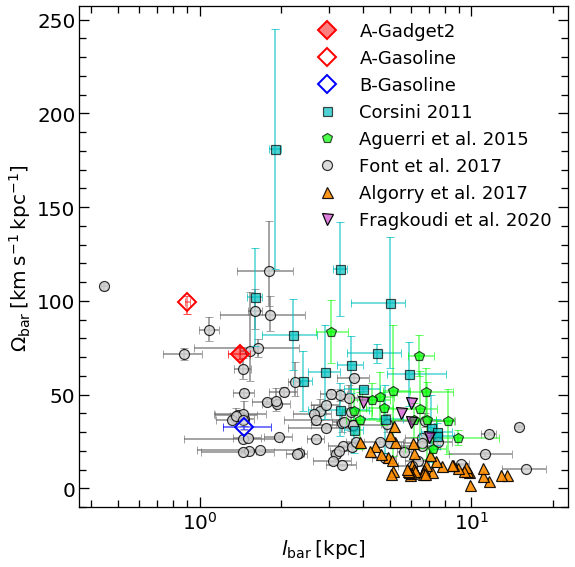

In [132]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.colors as color

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)

fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)

font, = ax.plot(rbar2,omega,'o', markersize=10, mec='k' ,mfc='lightgray', mew=1.2, alpha=0.8, label='Font et al. 2017')
ax.errorbar(rbar2,omega,xerr =sigma_rbar,yerr=[om_low,om_up], ecolor='dimgray', alpha=0.6, elinewidth=2,fmt='none' , capsize=4, zorder=1)

corsini, = ax.plot(l_bar,om_cor,'s', markersize=9, mec='k',mew=1.2,mfc='c', zorder=8, alpha= 0.7, label='Corsini 2011')
ax.errorbar(l_bar,om_cor,xerr=[lbar_er,lbar_e], yerr=eom_cor, ecolor='c', alpha= 0.7,fmt='none', capsize=4)

aguerri, = ax.plot(lbar_aguerri, Obar_aguerri,'p', markersize=10, mec='k',mew=1.2,mfc='lime', zorder=8, alpha= 0.7, label='Aguerri et al. 2015')
ax.errorbar(
    lbar_aguerri,
    Obar_aguerri,
    xerr=[lmin_aguerri,lmax_aguerri],
    yerr=Oerr_aguerri,
    ecolor='lime',
    fmt='none',
    capsize=4,
    alpha=0.6,
)
# ax.errorbar(l_bar,om_cor,xerr=[lbar_er,lbar_e], yerr=eom_cor, ecolor='c', alpha= 0.7,fmt='none', capsize=4)

algorry, = ax.plot(lbar_david,om_david,'^', markersize=11, mec='k', mew=1.2, mfc='darkorange',alpha=0.9, label='Algorry et al. 2017')
fragkoudi, = ax.plot(lbar_fgk_2, omega_fgk,'v',ms=11,mec='k',mew=1.2,mfc=color.to_rgba('m',0.5), label='Fragkoudi et al. 2020',zorder=20)

AGD, = ax.plot(lbar_M31gd, Obar_M31gd,'D', markersize=13, mec='r',mfc=color.to_rgba('r',0.5), mew=2,label='A-Gadget2',zorder=10)
ax.errorbar(
    lbar_M31gd,
    Obar_M31gd,
    xerr=[[lbar_M31gd-lmin_M31gd],[lmax_M31gd-lbar_M31gd]],
    yerr=[[Obar_M31gd-Omin_M31gd],[Omax_M31gd-Obar_M31gd]],
    ecolor='r',
    alpha= 0.7,
    fmt='none',
    capsize=4,
)

AGS, = ax.plot(lbar_M31gs, Obar_M31gs,'D', markersize=13, mec='r',mfc=color.to_rgba('w',0.2), mew=2,label='A-Gasoline',zorder=10)
ax.errorbar(
    lbar_M31gs,
    Obar_M31gs,
    xerr=[[lbar_M31gs-lmin_M31gs],[lmax_M31gs-lbar_M31gs]],
    yerr=[[Obar_M31gs-Omin_M31gs],[Omax_M31gs-Obar_M31gs]],
    ecolor='r',
    alpha= 0.7,
    fmt='none',
    capsize=4,
)

BGS, = ax.plot(lbar_MWgs,  Obar_MWgs, 'D', markersize=13, mec='b',mfc=color.to_rgba('w',0.2), mew=2,label='B-Gasoline',zorder=10)
ax.errorbar(
    lbar_MWgs,
    Obar_MWgs,
    xerr=[[lbar_MWgs-lmin_MWgs],[lmax_MWgs-lbar_MWgs]],
    yerr=[[Obar_MWgs-Omin_MWgs],[Omax_MWgs-Obar_MWgs]],
    ecolor='b',
    alpha= 0.7,
    fmt='none',
    capsize=4,
)


ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.set_ylabel('$\mathrm{\Omega_{bar}\:[km\:s^{-1}\:kpc^{-1}]}$', fontsize=20)
ax.set_xlabel('$l_{\mathrm{bar}}\:\mathrm{[kpc]}$', fontsize=20)
ax.set_xscale('log')
# ax.set_ylim(0,200)
# ax.set_xlim(0.4,20)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
# ax.xaxis.set_minor_locator(MultipleLocator(1/4.)) aa
# ax[0,0].fill_between([7,15],0,0.14, facecolor='k', alpha=0.2, color='k') #, hatch='\\'
ax.legend(handles=[AGD,AGS,BGS,corsini,aguerri, font ,algorry, fragkoudi],fontsize=18, frameon=False, loc=1) #,handletextpad= 0.01

# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/lbar_time.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('../_imagenes/correcciones/omega_lbar_new.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

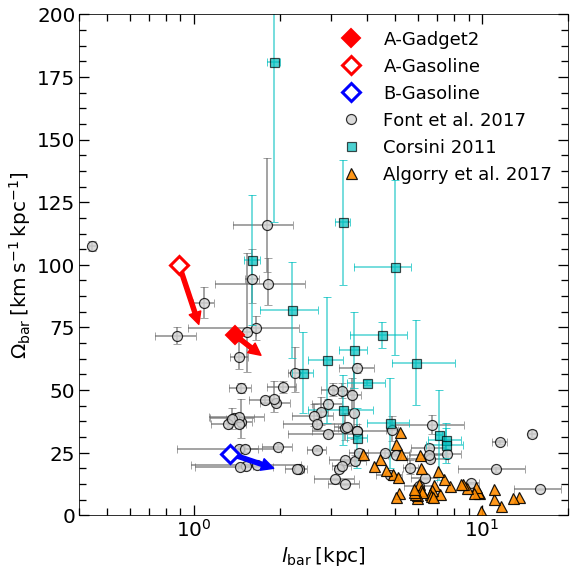

In [10]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)

fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)

font, = ax.plot(rbar2,omega,'o', markersize=10, mec='k' ,mfc='lightgray', mew=1.2, alpha=0.8, label='Font et al. 2017')
ax.errorbar(rbar2,omega,xerr =sigma_rbar,yerr=[om_low,om_up], ecolor='dimgray', alpha=0.6, elinewidth=2,fmt='none' , capsize=4, zorder=1)

corsini, = ax.plot(l_bar,om_cor,'s', markersize=9, mec='k',mew=1.2,mfc='c', zorder=8, alpha= 0.7, label='Corsini 2011')
ax.errorbar(l_bar,om_cor,xerr=[lbar_er,lbar_e], yerr=eom_cor, ecolor='c', alpha= 0.7,fmt='none', capsize=4)

algorry, = ax.plot(lbar_david,om_david,'^', markersize=11, mec='k', mew=1.2, mfc='darkorange',alpha=0.9, label='Algorry et al. 2017')

AGD, = ax.plot(lbar1_M31gd, omega12_M31gd,'D', markersize=13, mec='r',mfc='r', mew=2,label='A-Gadget2',zorder=20)
AGS, = ax.plot(lbar1_M31gs, omega12_M31gs,'D', markersize=13, mec='r',mfc='w', mew=3,label='A-Gasoline',zorder=20)
BGS, = ax.plot(lbar1_MWgs,  omega12_MWgs, 'D', markersize=13, mec='b',mfc='w', mew=3,label='B-Gasoline',zorder=20)
ax.annotate("", xytext=(lbar1_M31gd,omega12_M31gd), xy=(lbar6_M31gd, omega62_M31gd),
            arrowprops=dict(facecolor='r',edgecolor='r',lw=1.5),zorder=19)
ax.annotate("", xytext=(lbar1_M31gs,omega12_M31gs), xy=(lbar6_M31gs, omega62_M31gs),
            arrowprops=dict(facecolor='r',edgecolor='r',lw=1.5),zorder=19)
ax.annotate("", xytext=(lbar1_MWgs,omega12_MWgs), xy=(lbar6_MWgs, omega62_MWgs),
            arrowprops=dict(facecolor='b',edgecolor='b',lw=1.5),zorder=19)
# ax.text(1.9,-0.65,'method 3',fontsize=22, color='k',ha='left',va='center')

ax.set_ylabel('$\mathrm{\Omega_{bar}\:[km\:s^{-1}\:kpc^{-1}]}$', fontsize=20)
ax.set_xlabel('$l_{\mathrm{bar}}\:\mathrm{[kpc]}$', fontsize=20)
ax.set_xscale('log')
ax.set_ylim(0,200)
ax.set_xlim(0.4,20)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
# ax.xaxis.set_minor_locator(MultipleLocator(1/4.)) aa
# ax[0,0].fill_between([7,15],0,0.14, facecolor='k', alpha=0.2, color='k') #, hatch='\\'
ax.legend(handles=[AGD,AGS,BGS,font,corsini,algorry],fontsize=18, frameon=False, loc=1) #,handletextpad= 0.01

# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/lbar_time.pdf', dpi = 100, xxbox_inches='tight')
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/omega_lbar.pdf', dpi = 100, xxbox_inches='tight')
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'omega_lbar.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

#### Leemos todos los omegabar

In [22]:
GADGET = np.loadtxt('../_data/correcciones/rcorot_time_GD_new.dat')
# time_M31gd    = GADGET[:,0]

rcorot12_M31gd = GADGET[0,5]
rcorot32_M31gd = GADGET[0,6]
rcorot42_M31gd = GADGET[0,7]
rcorot52_M31gd = GADGET[0,8]


In [23]:
Rcorbar_M31gd = (rcorot12_M31gd + rcorot32_M31gd + rcorot42_M31gd + rcorot52_M31gd) / 4
Rcormin_M31gd = min(rcorot12_M31gd,rcorot32_M31gd,rcorot42_M31gd,rcorot52_M31gd)
Rcormax_M31gd = max(rcorot12_M31gd,rcorot32_M31gd,rcorot42_M31gd,rcorot52_M31gd)
print(Rcorbar_M31gd)

2.1330322649999998


In [24]:
GASOLINE1 = np.loadtxt('../_data/correcciones/rcorot_time_GS_new_001.dat')

rcorot12_M31gs = GASOLINE1[0,5]
rcorot32_M31gs = GASOLINE1[0,6]
rcorot42_M31gs = GASOLINE1[0,7]
rcorot52_M31gs = GASOLINE1[0,8]

GASOLINE2 = np.loadtxt('../_data/correcciones/rcorot_time_GS_new_002.dat')

rcorot12_MWgs = GASOLINE2[0,5]
rcorot32_MWgs = GASOLINE2[0,6]
rcorot42_MWgs = GASOLINE2[0,7]
rcorot52_MWgs = GASOLINE2[0,8]


In [25]:
Rcorbar_M31gs = (rcorot12_M31gs + rcorot32_M31gs + rcorot42_M31gs + rcorot52_M31gs) / 4
Rcormin_M31gs = min(rcorot12_M31gs,rcorot32_M31gs,rcorot42_M31gs,rcorot52_M31gs)
Rcormax_M31gs = max(rcorot12_M31gs,rcorot32_M31gs,rcorot42_M31gs,rcorot52_M31gs)
print(Rcorbar_M31gs)

1.5882373150000002


In [26]:
Rcorbar_MWgs = (rcorot12_MWgs + rcorot32_MWgs + rcorot42_MWgs + rcorot52_MWgs) / 4
Rcormin_MWgs = min(rcorot12_MWgs,rcorot32_MWgs,rcorot42_MWgs,rcorot52_MWgs)
Rcormax_MWgs = max(rcorot12_MWgs,rcorot32_MWgs,rcorot42_MWgs,rcorot52_MWgs)
print(Rcorbar_MWgs)

3.78478247


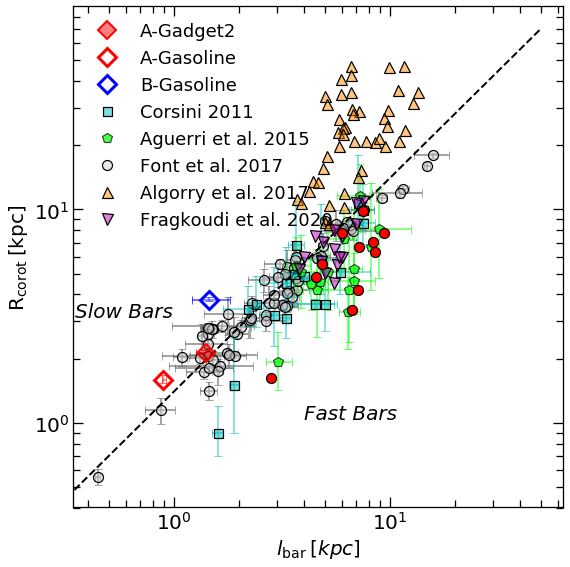

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import matplotlib.colors as color


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)

AGD, = ax.plot(lbar_M31gd, Rcorbar_M31gd,'D', markersize=13, mec='r',mfc=color.to_rgba('r',0.5), mew=2,label='A-Gadget2',zorder=20)
ax.errorbar(
    lbar_M31gd,
    Rcorbar_M31gd,
    xerr=[[lbar_M31gd-lmin_M31gd],[lmax_M31gd-lbar_M31gd]],
    yerr=[[Rcorbar_M31gd-Rcormin_M31gd],[Rcormax_M31gd-Rcorbar_M31gd]],
    ecolor='r',
    alpha= 0.7,
    fmt='none',
    capsize=4,
)
AGS, = ax.plot(lbar_M31gs, Rcorbar_M31gs,'D', markersize=13, mec='r',mfc=color.to_rgba('w',0.2), mew=3,label='A-Gasoline',zorder=20)
ax.errorbar(
    lbar_M31gs,
    Rcorbar_M31gs,
    xerr=[[lbar_M31gs-lmin_M31gs],[lmax_M31gs-lbar_M31gs]],
    yerr=[[Rcorbar_M31gs-Rcormin_M31gs],[Rcormax_M31gs-Rcorbar_M31gs]],
    ecolor='r',
    alpha= 0.7,
    fmt='none',
    capsize=4,
)

BGS, = ax.plot(lbar_MWgs,  Rcorbar_MWgs, 'D', markersize=13, mec='b',mfc=color.to_rgba('w',0.2), mew=3,label='B-Gasoline',zorder=20)
ax.errorbar(
    lbar_MWgs,
    Rcorbar_MWgs,
    xerr=[[lbar_MWgs-lmin_MWgs],[lmax_MWgs-lbar_MWgs]],
    yerr=[[Rcorbar_MWgs-Rcormin_MWgs],[Rcormax_MWgs-Rcorbar_MWgs]],
    ecolor='b',
    alpha= 0.7,
    fmt='none',
    capsize=4,
)

font, = ax.plot(rbar2,rCR2,'o', markersize=10, mec='k',mfc=color.to_rgba('lightgray',0.5), mew=1.2, label='Font et al. 2017')
ax.errorbar(rbar2,rCR2,xerr=sigma_rbar, yerr=sigma_rCR, ecolor='dimgray', alpha=0.6, elinewidth=2, fmt='none', capsize=4,zorder=1)

corsini, = ax.plot(l_bar,rcor,'s', markersize=9, mec='k',mew=1.2, mfc=color.to_rgba('c',0.5), zorder=8, label='Corsini 2011')
ax.errorbar(l_bar,rcor,xerr=[lbar_er,lbar_e], yerr=[rcor_er,rcor_e], ecolor='c', fmt='none', capsize=4, alpha=0.6)

aguerri, = ax.plot(
    lbar_aguerri,
    Rcr_aguerri,
    'p',
    markersize=10,
    mec='k',
    mew=1.2,
    mfc='lime',
    zorder=8,
    alpha= 0.7,
    label='Aguerri et al. 2015',
)
ax.errorbar(
    lbar_aguerri,
    Rcr_aguerri,
    xerr=[lmin_aguerri,lmax_aguerri],
    yerr=[Rmin_aguerri,Rmax_aguerri],
    ecolor='lime',
    fmt='none',
    capsize=4,
    alpha=0.6,
)

ax.plot(Lbar_aguerri_2,Rcor_aguerri_2,'o', markersize=10, mec='k',mew=1.2,mfc='r',zorder=20)

algorry, = ax.plot(lbar_david0,rcor_david0,'^', markersize=11, mec='k', mew=1.2, mfc=color.to_rgba('darkorange',0.5), 
                   label='Algorry et al. 2017')

fragkoudi, = ax.plot(lbar_fgk,Rcorot_fgk,'v',ms=11,mec='k',mew=1.2,mfc=color.to_rgba('m',0.5), label='Fragkoudi et al. 2020', zorder=15)
# ax.plot(lbar_fgk_2,Rcorot_fgk_2,'o',ms=11,mec='k',mew=1.2,mfc='r', zorder=15)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.plot([0,50],[0,70], 'k--', lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_minor_locator(MultipleLocator(1/5.))
ax.xaxis.set_minor_locator(MultipleLocator(1/5.))
# ax.set_xlim(0.3,20)
# ax.set_ylim(0.3,70)
# ax.set_ylim(1,6)
# ax.set_xlim(0.5,2)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)#,colors='w')
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)#,colors='w')  
ax.set_xlabel(r'$l_{\mathrm{bar}}\:[kpc]$', fontsize=20)#, color='lightgray')
ax.set_ylabel(r'$\mathrm{R_{corot}\:[kpc]}$',fontsize=20)#, color='lightgray')

ax.text(x = 0.35, y = 3, s = 'Slow Bars', fontsize = 20, va = 'bottom', ha = 'left', color='k', style='italic')
ax.text(x = 4, y = 1, s = 'Fast Bars', fontsize = 20, va = 'bottom', ha = 'left',  color='k', style='italic')
ax.legend(handles=[AGD,AGS,BGS,corsini, aguerri, font ,algorry,fragkoudi],fontsize=18, frameon=False, loc=2)

fig.savefig('../_imagenes/correcciones/rcorot_lbar_new.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

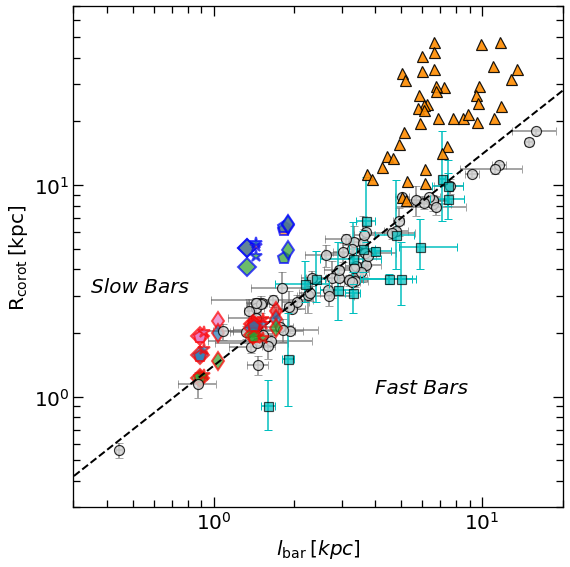

In [13]:
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)

# AGD, = ax.plot(lbar1_M31gd, M31gd_Rcorot1,'D', markersize=13, mec='r',mfc='r', mew=2,label='A-Gadget2',zorder=20)
# ax.plot(M31gd_lbar2, M31gd_Rcorot2,'p', markersize=13, mec='r',mfc='r', mew=2,zorder=20)
# ax.plot(M31gd_lbar3, M31gd_Rcorot3,'*', markersize=16, mec='r',mfc='r', mew=2,zorder=20)
# ax.plot(M31gd_lbar4, M31gd_Rcorot4,'d', markersize=13, mec='r',mfc='r', mew=2,zorder=20)

ax.plot(lbar1_M31gd, rcorot11_M31gd,'D', markersize=13, mec='r',mfc='tab:red',   mew=2,alpha=0.7,zorder=20)
ax.plot(lbar1_M31gd, rcorot12_M31gd,'D', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7,zorder=20)
ax.plot(lbar1_M31gd, rcorot13_M31gd,'D', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7,zorder=20)
ax.plot(lbar5_M31gd, rcorot51_M31gd,'p', markersize=13, mec='r',mfc='tab:red',   mew=2,alpha=0.7,zorder=20)
ax.plot(lbar5_M31gd, rcorot52_M31gd,'p', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7,zorder=20)
ax.plot(lbar5_M31gd, rcorot53_M31gd,'p', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7,zorder=20)
ax.plot(lbar3_M31gd, rcorot31_M31gd,'*', markersize=13, mec='r',mfc='tab:red',   mew=2,alpha=0.7,zorder=20)
ax.plot(lbar3_M31gd, rcorot32_M31gd,'*', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7,zorder=20)
ax.plot(lbar3_M31gd, rcorot33_M31gd,'*', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7,zorder=20)
ax.plot(lbar6_M31gd, rcorot61_M31gd,'d', markersize=13, mec='r',mfc='tab:red',   mew=2,alpha=0.7,zorder=20)
ax.plot(lbar6_M31gd, rcorot62_M31gd,'d', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7,zorder=20)
ax.plot(lbar6_M31gd, rcorot63_M31gd,'d', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7,zorder=20)

# AGS, = ax.plot(lbar1_M31gs, M31gs_Rcorot1,'D', markersize=13, mec='r',mfc='w', mew=2,label='A-Gasoline',zorder=20)
# ax.plot(M31gs_lbar2, M31gs_Rcorot2,'p', markersize=13, mec='r',mfc='w', mew=2,zorder=20)
# ax.plot(M31gs_lbar3, M31gs_Rcorot3,'*', markersize=16, mec='r',mfc='w', mew=2,zorder=20)
# ax.plot(M31gs_lbar4, M31gs_Rcorot4,'d', markersize=13, mec='r',mfc='w', mew=2,zorder=20)

ax.plot(lbar1_M31gs, rcorot11_M31gs,'D', markersize=13, mec='r',mfc='tab:pink',  mew=2,alpha=0.7)
ax.plot(lbar1_M31gs, rcorot12_M31gs,'D', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7)
ax.plot(lbar1_M31gs, rcorot13_M31gs,'D', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7)
ax.plot(lbar5_M31gs, rcorot51_M31gs,'p', markersize=13, mec='r',mfc='tab:pink',  mew=2,alpha=0.7)
ax.plot(lbar5_M31gs, rcorot52_M31gs,'p', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7)
ax.plot(lbar5_M31gs, rcorot53_M31gs,'p', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7)
ax.plot(lbar3_M31gs, rcorot31_M31gs,'*', markersize=13, mec='r',mfc='tab:pink',  mew=2,alpha=0.7)
ax.plot(lbar3_M31gs, rcorot32_M31gs,'*', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7)
ax.plot(lbar3_M31gs, rcorot33_M31gs,'*', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7)
ax.plot(lbar6_M31gs, rcorot61_M31gs,'d', markersize=13, mec='r',mfc='tab:pink',  mew=2,alpha=0.7)
ax.plot(lbar6_M31gs, rcorot62_M31gs,'d', markersize=13, mec='r',mfc='tab:blue',  mew=2,alpha=0.7)
ax.plot(lbar6_M31gs, rcorot63_M31gs,'d', markersize=13, mec='r',mfc='tab:green', mew=2,alpha=0.7)

# BGS, = ax.plot(lbar1_MWgs,  MWgs_Rcorot1, 'D', markersize=13, mec='b',mfc='w', mew=2,label='B-Gasoline',zorder=20)
# ax.plot(MWgs_lbar2,  MWgs_Rcorot2, 'p', markersize=13, mec='b',mfc='w', mew=2,zorder=20)
# ax.plot(MWgs_lbar3,  MWgs_Rcorot3, '*', markersize=16, mec='b',mfc='w', mew=2,zorder=20)
# ax.plot(MWgs_lbar4,  MWgs_Rcorot4, 'd', markersize=13, mec='b',mfc='w', mew=2,zorder=20)

ax.plot(lbar1_MWgs, rcorot11_MWgs,'D', markersize=13, mec='b',mfc='tab:orange', mew=2,alpha=0.7)
ax.plot(lbar1_MWgs, rcorot12_MWgs,'D', markersize=13, mec='b',mfc='tab:blue',   mew=2,alpha=0.7)
ax.plot(lbar1_MWgs, rcorot13_MWgs,'D', markersize=13, mec='b',mfc='tab:green',  mew=2,alpha=0.7)
ax.plot(lbar5_MWgs, rcorot51_MWgs,'p', markersize=13, mec='b',mfc='tab:orange', mew=2,alpha=0.7)
ax.plot(lbar5_MWgs, rcorot52_MWgs,'p', markersize=13, mec='b',mfc='tab:blue',   mew=2,alpha=0.7)
ax.plot(lbar5_MWgs, rcorot53_MWgs,'p', markersize=13, mec='b',mfc='tab:green',  mew=2,alpha=0.7)
ax.plot(lbar3_MWgs, rcorot31_MWgs,'*', markersize=13, mec='b',mfc='tab:orange', mew=2,alpha=0.7)
ax.plot(lbar3_MWgs, rcorot32_MWgs,'*', markersize=13, mec='b',mfc='tab:blue',   mew=2,alpha=0.7)
ax.plot(lbar3_MWgs, rcorot33_MWgs,'*', markersize=13, mec='b',mfc='tab:green',  mew=2,alpha=0.7)
ax.plot(lbar6_MWgs, rcorot61_MWgs,'d', markersize=13, mec='b',mfc='tab:orange', mew=2,alpha=0.7)
ax.plot(lbar6_MWgs, rcorot62_MWgs,'d', markersize=13, mec='b',mfc='tab:blue',   mew=2,alpha=0.7)
ax.plot(lbar6_MWgs, rcorot63_MWgs,'d', markersize=13, mec='b',mfc='tab:green',  mew=2,alpha=0.7)

font, = ax.plot(rbar2,rCR2,'o', markersize=10, mec='k',mfc='lightgray', mew=1.2, alpha=0.8, label='Font et al. 2017')
ax.errorbar(rbar2,rCR2,xerr=sigma_rbar, yerr=sigma_rCR, ecolor='dimgray', alpha=0.6, elinewidth=2, fmt='none', capsize=4,zorder=1)

corsini, = ax.plot(l_bar,rcor,'s', markersize=9, mec='k',mew=1.2, mfc='c', zorder=8, alpha= 0.7, label='Corsini 2011')
ax.errorbar(l_bar,rcor,xerr=[lbar_er,lbar_e], yerr=[rcor_er,rcor_e], ecolor='c', fmt='none', capsize=4)

algorry, = ax.plot(lbar_david0,rcor_david0,'^', markersize=11, mec='k', mew=1.2, mfc='darkorange',alpha=0.9, label='Algorry et al. 2017')

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.plot([0,50],[0,70], 'k--', lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_minor_locator(MultipleLocator(1/5.))
ax.xaxis.set_minor_locator(MultipleLocator(1/5.))
ax.set_xlim(0.3,20)
ax.set_ylim(0.3,70)
# ax.set_ylim(1,6)
# ax.set_xlim(0.5,2)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)#,colors='w')
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)#,colors='w')  
ax.set_xlabel(r'$l_{\mathrm{bar}}\:[kpc]$', fontsize=20)#, color='lightgray')
ax.set_ylabel(r'$\mathrm{R_{corot}\:[kpc]}$',fontsize=20)#, color='lightgray')

ax.text(x = 0.35, y = 3, s = 'Slow Bars', fontsize = 20, va = 'bottom', ha = 'left', color='k', style='italic')
ax.text(x = 4, y = 1, s = 'Fast Bars', fontsize = 20, va = 'bottom', ha = 'left',  color='k', style='italic')
# ax.legend(handles=[AGD,AGS,BGS,font,corsini,algorry],fontsize=18, frameon=False, loc=2)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Rcor_lbar2.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

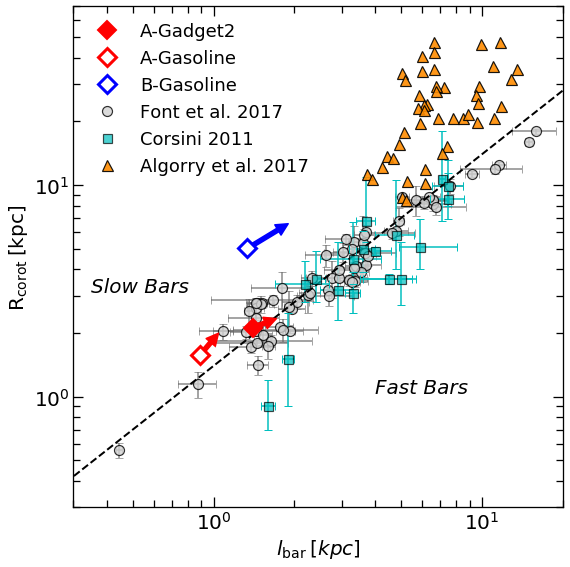

In [16]:
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)

AGD, = ax.plot(lbar1_M31gd, rcorot12_M31gd,'D', markersize=13, mec='r',mfc='r', mew=2,label='A-Gadget2',zorder=20)
AGS, = ax.plot(lbar1_M31gs, rcorot12_M31gs,'D', markersize=13, mec='r',mfc='w', mew=3,label='A-Gasoline',zorder=20)
BGS, = ax.plot(lbar1_MWgs,  rcorot12_MWgs, 'D', markersize=13, mec='b',mfc='w', mew=3,label='B-Gasoline',zorder=20)

ax.annotate("", xytext=(lbar1_M31gd,rcorot12_M31gd), xy=(lbar6_M31gd, rcorot62_M31gd),
            arrowprops=dict(facecolor='r',edgecolor='r',lw=1.5),zorder=19)
ax.annotate("", xytext=(lbar1_M31gs,rcorot12_M31gs), xy=(lbar6_M31gs, rcorot62_M31gs),
            arrowprops=dict(facecolor='r',edgecolor='r',lw=1.5),zorder=19)
ax.annotate("", xytext=(lbar1_MWgs,rcorot12_MWgs), xy=(lbar6_MWgs, rcorot62_MWgs),
            arrowprops=dict(facecolor='b',edgecolor='b',lw=1.5),zorder=19)

font, = ax.plot(rbar2,rCR2,'o', markersize=10, mec='k',mfc='lightgray', mew=1.2, alpha=0.8, label='Font et al. 2017')
ax.errorbar(rbar2,rCR2,xerr=sigma_rbar, yerr=sigma_rCR, ecolor='dimgray', alpha=0.6, elinewidth=2, fmt='none', capsize=4,zorder=1)

corsini, = ax.plot(l_bar,rcor,'s', markersize=9, mec='k',mew=1.2, mfc='c', zorder=8, alpha= 0.7, label='Corsini 2011')
ax.errorbar(l_bar,rcor,xerr=[lbar_er,lbar_e], yerr=[rcor_er,rcor_e], ecolor='c', fmt='none', capsize=4)

algorry, = ax.plot(lbar_david0,rcor_david0,'^', markersize=11, mec='k', mew=1.2, mfc='darkorange',alpha=0.9, label='Algorry et al. 2017')

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.plot([0,50],[0,70], 'k--', lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_minor_locator(MultipleLocator(1/5.))
ax.xaxis.set_minor_locator(MultipleLocator(1/5.))
ax.set_xlim(0.3,20)
ax.set_ylim(0.3,70)
# ax.set_ylim(1,6)
# ax.set_xlim(0.5,2)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)#,colors='w')
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)#,colors='w')  
ax.set_xlabel(r'$l_{\mathrm{bar}}\:[kpc]$', fontsize=20)#, color='lightgray')
ax.set_ylabel(r'$\mathrm{R_{corot}\:[kpc]}$',fontsize=20)#, color='lightgray')

ax.text(x = 0.35, y = 3, s = 'Slow Bars', fontsize = 20, va = 'bottom', ha = 'left', color='k', style='italic')
ax.text(x = 4, y = 1, s = 'Fast Bars', fontsize = 20, va = 'bottom', ha = 'left',  color='k', style='italic')
ax.legend(handles=[AGD,AGS,BGS,font,corsini,algorry],fontsize=18, frameon=False, loc=2)

path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'rcorot_lbar.pdf', dpi = 100, xxbox_inches='tight')
plt.show()